<a href="https://colab.research.google.com/github/Artcaramel/Machinelearning/blob/main/DeepLearning/%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신경망 모델 훈련
---
- 머신러닝 : 좋은 성능을 내기 위해 매개 변수를 조정하고 훈련하는 과정 반복
- 딥러닝 : 모델의 구조를 직접 만드는 과정
- 층을 추가하고 층의 뉴런의 개수와 활성화 함수 결정등


## 핵심 키워드
---
- 드롭아웃
- 콜백
- 조기 종료


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/7-3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 손실 곡선 History 객체
---
- fit() 메서드의 리턴값
- 훈련 과정에서 계산한 지표, 즉 손실과 정확도 값
- 이 값 그래프로 확인

In [1]:
# 데이터 준비
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


In [2]:
# 모델 만들기 사용자 함수 정의
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    # 은닉층 하나 추가
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [3]:
model = model_fn()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
# fit() 메서드 결과 저장
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

- verbose=0 : 훈련 결과 출력 조정 파라미터, 0 미출력, 1 출력, 2 진행 막대 빼고 출력

In [5]:
# 훈련 측정값 key 확인, 손실, 정확도
# 에포크마다 계산한 값이 순서래도 리스트로 저장되어 있음
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


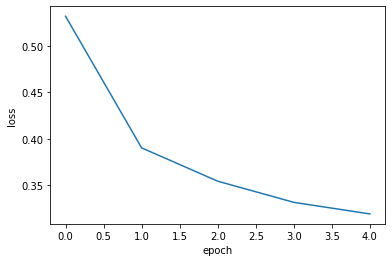

In [6]:
# 에포크별 손실 값 그래프로 확인
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

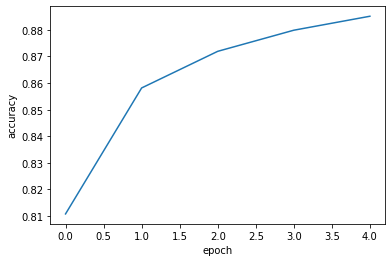

In [7]:
# 에포크별 정확도 값 그래프로 확인
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

- **에포크마다 손실은 감소, 정확도는 상승**

**에포크 epochs를 늘려 훈련**
---
- 에포크 20으로 늘려서 훈련
- 손실 그래프 확인

In [8]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

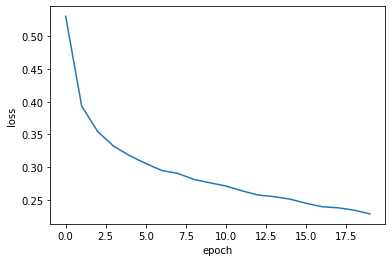

In [9]:
# 손실 그래프
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

- 손실이 감소

## 에포크에 따른 과대적합과 과소적합
----
- 손실값으로 과대/과소적합 확인
- 인공 신경망 모델이 최적화하는 대상은 손실 함수
- 손실 감소에 비례해서 정확도가 높아 지지 않음
- 모델의 평가시 정확도 보다는 손실 함수 값의 확인이 더 필요함
- 과대적합과 과소적합을 보려면 검증 데이터의 손실도 확인이 필요

### 검증 손실
---
- validation_data 파라미터에 검증 데이터 전달
- hisoty 객체 val_loss, val_accuracy 값에 저장되어 있음
- 검증 손실 작업은 시간이 조금 걸리니 GPU 사용 하면 좋음

In [10]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


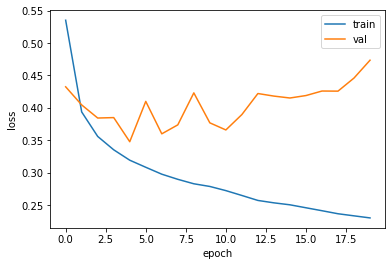

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- **훈련데이터는 꾸준이 손실이 감소하므로 전형적인 과대적합 모델이 만들어 짐**

### 하이퍼파라미터 조절로 과대적합 규제 
---
- 기본 optimizer RMSprop은 일반적으로 잘 작동
- RMSprop이 훈련, 검증 데이터 셋에 잘 맞지 않는 것 같다면  적응적 학습률을 optimizer에 Adam이 좋은 선택이 됨
- Adam은 확습률 조정도 가능 함
-  연구 결과에 따르면, Adam 알고리즘에서 학습률은 0.001 이 가장 좋은 설정이라고 아려져 있음
- 연구논문 : https://arxiv.org/pdf/1412.6980.pdf

In [13]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

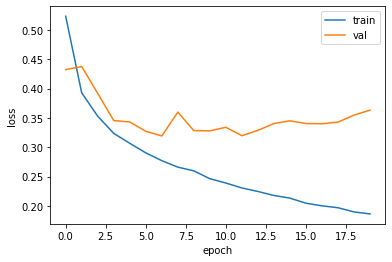

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- RMSprop 옵티마이저 보다는 과대적합이 전반적으로 감소 했음
- 이 데이터셋에는 Adam 옵티마이저가 더 잘 맞는 것으로 보임
- https://forensics.tistory.com/m/28

In [15]:
model = model_fn()
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

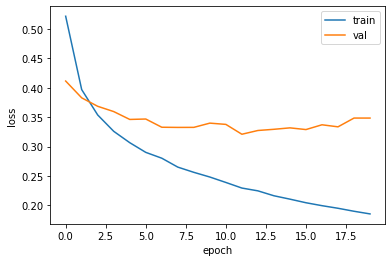

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 드롭아웃 dropout
---
- 딥러닝의 아버지 제프리 힌턴 Geoffrey Hinton이 소개(특허 등록)
- https://brunch.co.kr/@hvnpoet/46
- 훈련 과정에서 은닉층에 있는 일부 뉴런을 랜덤하게 출력을 0으로 만들어 과대적합을 막는 방법
- 뉴런은 랜덤하게 드롭되야 하며 몇 개를 드롭할지는 우리가 정해야하는 하이퍼파라미터 임
- 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있어 과대접합을 막어줌
- 드롭아웃을 적용해 훈련하는 것은 2개의 신경망을 앙상블 하는 것과 비슷
- karas.layers.Dropout 클래스를 적용할 은닉층 뒤에 추가 해서 사용

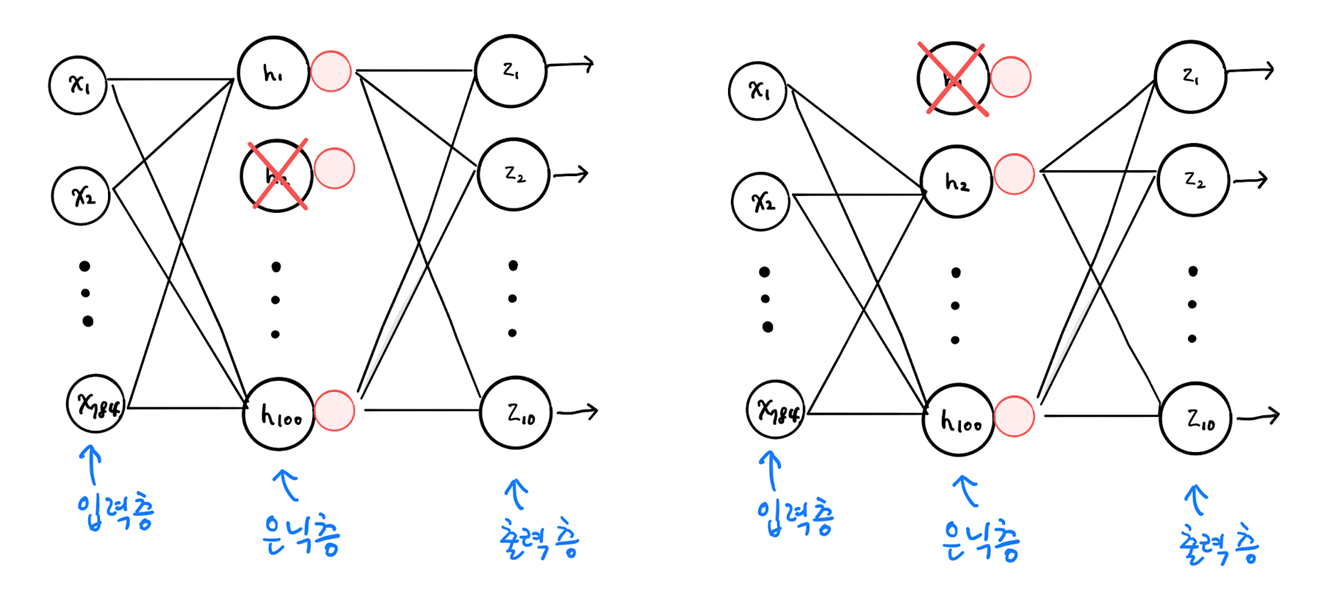

In [17]:
# 0.3 : 30% 드롭아웃
model = model_fn(keras.layers.Dropout(0.3))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

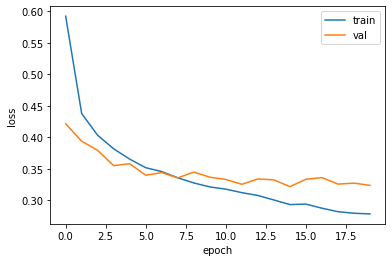

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 과대적합이 많이 줄었음
- 최적의 에포크는 10 정도

## 모델 저장과 복원
---
- 에포크 10으로 훈련 후 모델 저장
- save_weight() 메서드 : 훈련된 모델의 파라미터 저장
- save() 메서드 : 모델 과 모델 파라미터 함께 저장
- 텐서플로우의 SavedModel 포맷이나 h5 일경우 HDF5 포맷으로 저장 됨 

**참고 - HDF5**
HDF5는 Hierarchical Data Format이며 고성능 데이터포맷 또는 DB 정도로 이해할 수 있다. 운영체계와 무관하게 사용할 수 있으며, 대용량 데이터를 빠르게 읽고 쓸 수 있다.
- https://wikidocs.net/33122

In [20]:
# 10 에포크로 재 학습
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [21]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3241 - accuracy: 0.8845


[0.32407352328300476, 0.8845000267028809]

In [22]:
# 모델 파라미터 저장
model.save_weights('model-weights.h5')

In [23]:
# 모델 과 모델 파라미터 저장
model.save('model-whole.h5')

In [24]:
!ls -al *.h5  

-rw-r--r-- 1 root root 333448 Oct 26 06:46 model-weights.h5
-rw-r--r-- 1 root root 982664 Oct 26 06:46 model-whole.h5


### 저장 모델 파라미터 불러와서 평가
---
- 1. 모델 생성
- 2. 훈련된 모델 파라미터 로드 load_weights() 
- 3. 검증데이터 예측
- 4. 검증 데이터 평가

In [25]:
model = model_fn(keras.layers.Dropout(0.3))

model.load_weights('model-weights.h5')

In [26]:
import numpy as np

# axis  0 첫번째축, -1 마지막 축
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 [==============================] - 1s 1ms/step
0.8845


In [27]:
pred = model.predict(val_scaled)

375/375 [==============================] - 1s 1ms/step


In [28]:
pred.shape

(12000, 10)

In [29]:
pred[0]

array([6.3235386e-09, 1.5417916e-14, 2.4296687e-09, 6.9674475e-12,
       1.5775877e-09, 1.1889513e-05, 1.2733609e-09, 1.2307412e-07,
       9.9998796e-01, 8.6209130e-12], dtype=float32)

In [30]:
np.max(pred[0]),np.argmax(pred[0])

(0.99998796, 8)

### 저장 모델 불러와서 평가
---
- 1. 훈련된 모델 로드 load_model() 
- 2. 검증 데이터 셋으로 평가 model.evaluate() 

In [31]:
model = keras.models.load_model('model-whole.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3241 - accuracy: 0.8845


[0.32407352328300476, 0.8845000267028809]

- **모두 0.8825로 정확도 동일**
- 참고 : 테서플로 2.3에서는 load_model() 버그로 load_model() 호출 전에 compile() 호출해야 함

## 콜백 callback
---
- keras.callbacks.ModelCheckpoint()
- 에포크 마다 모델을 저장
- save_best_only=True 최적의 검증 값의 모델 저장 
- 최적의 검증 값의 모델을 찾아도 에포크 횟수 전체 진행 됨 => 조기 종료 필요




In [32]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0, 
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [33]:
model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3142 - accuracy: 0.8903


[0.31420913338661194, 0.890250027179718]

### 조기 종료 early stopping
---
- keras.callbacks.EarlyStopping 클래스 제공
- patience 파라미터 검증 점수 향상 되지 않아도 참을 에포크 횟수
- restore_best_weights=True 가장 낮은 검증 손실 파라미터로 되돌려 저장
- stopped_epoch 훈련이 중지된 에포크 값, 0부터 시작됨

In [34]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [35]:
print(early_stopping_cb.stopped_epoch)

8


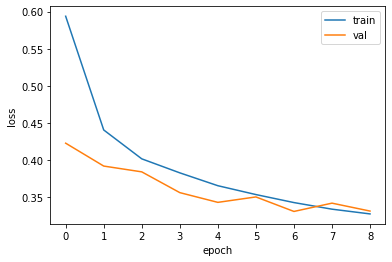

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3307 - accuracy: 0.8776


[0.3307053744792938, 0.8775833249092102]